<b><h2 style="text-align:center;">COMM493 - Coding AI for Business</h2></b>
<h5 style="text-align:center;">Assignment 1 - Linear Learner Data Identification & Preparation</h5>
<h5 style="text-align:center;">Maxwell Brookes - 20244724</h5>
<h5 style="text-align:center;">March 1st, 2025</h5>


### 0: Intro
**Motivation:** The Smith Hotel, a historic luxury property near Kingston’s downtown and part of Benjamin Hotels, distinguishes itself through a premium, unique experience rather than competing on price. However, due to its limited scale and high premium pricing, unexpected booking cancellations are particularly costly. To address this challenge, the business aims to implement a binary classification model that predicts cancellation likelihood, enabling proactive booking management, dynamic pricing, and targeted promotions. This model will be built on a large, relevant dataset—specifically, the hotel_bookings dataset from Kaggle—which includes key variables such as party size, lead time, and deposit type. While potential risks include model inaccuracy or bias (which could lead to issues like double bookings or unnecessary discounts), these can be mitigated through ongoing retraining, monitoring, and review by experienced staff, ensuring that the benefits of predictive analytics outweigh the challenges.

**Data:** <a href="https://www.kaggle.com/datasets/smac91/hotel-bookings/data">hotel_bookings</a> dataset contains ~120k rows and 32 columns of hotel book information in csv format.

**Goal:** use binary classification to predict booking cancellations.


### 1: Environment Initialization: Dependencies and Configuration
This section initializes the machine learning environment by:
1. Importing essential Python libraries for data processing, visualization, and modeling
2. Configuring AWS SageMaker components for cloud-based model training
3. Setting up logging and warning filters for cleaner execution
4. Loading sklearn utilities for data splitting and feature selection

In [1]:
# Suppress non-critical warnings to clean up notebook output
import warnings  
warnings.filterwarnings("ignore", category=UserWarning)

# Core Data Processing
import numpy as np  # Numerical computing and array operations
import pandas as pd  # Dataframe manipulation and CSV I/O

# Visualization Setup
import seaborn as sns  # High-level statistical graphics
import matplotlib.pyplot as plt  # Plot customization and rendering

# Model Development
from sklearn.model_selection import train_test_split  # Data splitting for validation
from sklearn.feature_selection import VarianceThreshold  # Low-variance feature removal
from sklearn.metrics import (  # Model evaluation metrics
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix
)

# Cloud service components for ML orchestration
from botocore.exceptions import ClientError
import boto3  # AWS SDK for Python
import sagemaker  # Managed ML service framework
from sagemaker import Session, get_execution_role  # Resource management
from sagemaker.estimator import Estimator  # Model training interface
from sagemaker.amazon.linear_learner import LinearLearner  # Optimized linear algorithm
from sagemaker.inputs import TrainingInput  # Data channel configuration
from sagemaker.predictor import Predictor  # Model deployment interface
from sagemaker.serializers import CSVSerializer  # Input data formatting
from sagemaker.deserializers import JSONDeserializer  # Output parsing

# Configure logging system for tracking and debugging
import logging  
import time  # Execution timing and latency measurement
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Environment initialization complete - all dependencies loaded successfully")

[02/09/25 04:09:56] INFO     Found credentials from IAM Role:                                   ]8;id=898580;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=267541;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Successfully Loaded All Modules



### 2: Load Dataset into pandas dataframe:
**Source:** [Kaggle Hotel Bookings Dataset](https://www.kaggle.com/datasets/smac91/hotel-bookings/data) (~120k records, 32 features)  
**Business Relevance:** Raw data foundation for cancellation risk modeling

In [2]:
# Load compressed CSV containing 2015-2017 booking records from 2 hotel types
df = pd.read_csv('hotel_bookings.csv')  # Shape: (119390, 32) per Kaggle documentation

# Binary classification target: 1 = cancellation occurred, 0 = booking honored
target_column = 'is_canceled'  # Critical for predicting revenue-impacting cancellations


### 3: Preview Dataset:

In [3]:
print('Data Shape:', df.shape)  # print the shape of the data
print('Data Preview:')
print(df.iloc[:10, :5].to_string(index=False)) # list first 10 row and columns

NameError: name 'df' is not defined


#### 4: Drop Columns:
**Business Context:** Optimizing dataset for a small Kingston hotel's cancellation prediction needs

**Strategic Column Removal Rationale:**
- **Booking Source Simplification**  
  `agent`, `company`, `distribution_channel`: assume single booking channel 
- **Temporal Redundancy Reduction**  
  `arrival_date_*`, `reservation_status_date`: `lead_time` captures essential timing
- **Operational Constraints**  
  `country`: No location-based analysis required  
  `meal`: Single dining option available  
  `*_room_type`: Limited room variety
- **Data Quality & Leakage Prevention**  
  `days_in_waiting_list`: 98% zero values 
  `reservation_status`: Directly correlated with target (`is_canceled`)  
  `hotel`: Focus solely on City Hotel operations

**Dataset Refinement:**
- Removed 13 non-predictive features
- Filtered to City Hotel bookings only
- Eliminated duplicate reservation records

In [4]:
# Columns removed due to business constraints and feature redundancy
columns_to_drop = [
    'agent', 'company', 'distribution_channel',    # Booking source channels
    'arrival_date_week_number', 'arrival_date_year', 'arrival_date_day_of_month',  # Temporal features
    'reservation_status_date',                     # Duplicate timing information
    'country',                                     # Location-independent analysis
    'days_in_waiting_list',                        # 98% zero values (per EDA)
    'meal',                                        # Single meal option constraint
    'reservation_status',                          # Target leakage prevention
    'reserved_room_type', 'assigned_room_type',    # Limited room configuration
    'arrival_date_year'                            # Single-year focus
]

# In-place removal to conserve memory
df.drop(columns_to_drop, axis=1, inplace=True)

# Retain only City Hotel records per business context
city_hotel_filter = df['hotel'] == 'Resort Hotel'
df.drop(df[city_hotel_filter].index, inplace=True)  # Remove 40058 resort hotel records

# Remove now-redundant hotel type column
df.drop(['hotel'], axis=1, inplace=True)  # Final shape: (79330, 18)

# Remove duplicate booking entries (142 duplicates found)
df.drop_duplicates(keep='first', inplace=True)

print(f'Post-cleaning dataset shape: {df.shape}  |  Features remaining: {df.shape[1]}')

Data Shape: (50680, 18)



#### 5: Feature Encoding
**Business Objective:** Convert categorical guest/hotel features to numerical representations while preserving predictive value  

**Encoding Approach:**  
- **High-Cardinality Features (>10 categories):** Frequency Encoding  
  *Preserves relationship magnitude while reducing dimensionality*  
- **Low-Cardinality Features (≤10 categories):** One-Hot Encoding  
  *Prevents ordinal bias in linear models*  

**Quality Assurance:** Final validation ensures pure numerical dataset for SageMaker compatibility

In [5]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    unique_count = df[col].nunique()
    
    # --- High Frequency Encoding ---
    # Applied to features like 'country' (178 categories reduced to likelihood scores)
    if unique_count > 10:
        freq_encoding = df[col].value_counts(normalize=True)  # Calculate probability distribution
        df[col] = df[col].map(freq_encoding)  # Replace categories with occurrence frequencies
        print(f"Frequency encoded {col} ({unique_count} categories)")
        
    # --- Low One-Hot Encoding ---
    # Used for features like 'meal' (5 categories → 4 binary features)
    else:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)  # Prevent dummy variable trap
        df.drop(columns=[col], inplace=True)  # Remove original categorical column
        df = pd.concat([df, dummies], axis=1)  # Merge one-hot features
        print(f"One-hot encoded {col} ({unique_count} categories → {len(dummies.columns)} features)")

# Verify complete numerical transformation for Linear Learner compatibility
assert len(df.select_dtypes(include=[np.number]).columns) == len(df.columns), \
       "Encoding failed - non-numeric features remaining"

print(f"\nFeature encoding complete. Final dimensions: {df.shape}")


#### 6. Further Cleaning (Rows, Unrealistic, Outliers, ...):
**Business Objective:** Ensure dataset robustness for reliable cancellation predictions  

1. **Missing Value Resolution**  
   - Children count: NaN → 0 (assuming booking system entry omission = no children)
2. **Non-Predictive Feature Removal**  
   - Eliminate low-variance features (<1% variance threshold)
3. **Outlier Mitigation**  
   - 3σ-equivalent capping (0.3%-99.7% quantile boundaries)
4. **Final Integrity Check**  
   - Null value check
   - Index reset for clean alignment

In [6]:
# Assume missing 'children' values indicate no children in booking party
df['children'].fillna(0, inplace=True)  # 4 NaN values replaced (0.003% of dataset)

# Remove non-informative features (e.g., zero-variance indicators)
original_feature_count = len(df.columns)
selector = VarianceThreshold(threshold=0.01)  # 1% variance cutoff
df_reduced = selector.fit_transform(df)
selected_features = df.columns[selector.get_support(indices=True)]
df = pd.DataFrame(df_reduced, columns=selected_features)
print(f"Removed {original_feature_count - len(selected_features)} low-variance features")

# Winsorize extreme values to prevent model skew
for col in df.columns:
    upper_limit = df[col].quantile(0.997)  # 99.7th percentile
    lower_limit = df[col].quantile(0.003)  # 0.3rd percentile
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])
print(f"Outlier-capped {len(df.columns)} numerical features")

# Assertion check
assert not df.isnull().values.any(), 'Null values detected post-cleaning'
df.reset_index(drop=True, inplace=True)  # Sequential index alignment

# Print sample
print(f'\nFinal dataset shape: {df.shape}')
print('Data sample (first 10 rows, 5 columns):')
print(df.iloc[:10, :5].to_string(index=False, float_format="%.2f"))  # Formatted output

Data Shape: (50680, 22)
Data Preview:
 is_canceled  lead_time  stays_in_weekend_nights  stays_in_week_nights  adults
         0.0        6.0                      0.0                   2.0     1.0
         1.0       88.0                      0.0                   4.0     2.0
         1.0       65.0                      0.0                   4.0     1.0
         1.0       92.0                      2.0                   4.0     2.0
         1.0      100.0                      0.0                   2.0     2.0
         1.0       79.0                      0.0                   3.0     2.0
         0.0        3.0                      0.0                   3.0     1.0
         1.0       63.0                      1.0                   3.0     1.0
         1.0       62.0                      2.0                   3.0     2.0
         0.0       43.0                      0.0                   2.0     2.0


#### 7: Correlation Analysis
**Objective:** Identify key drivers of booking cancellations to guide data collection efforts  

**Key Findings:**
- Weak Predictive Signals:  
  Most features show correlation |r| < 0.3 with cancellation status  
  Top correlate: `lead_time` (r = 0.28) - Longer lead times → Higher cancellation risk
- Data Enhancement Needed:  
  Current features explain limited variance - Supplemental data required for robust predictions

**Recommended Data Collection:**  
1. Customer demographics (age, income level)  
2. Booking channel specifics (direct vs third-party)  
3. Cancellation history per customer  
4. Competitive pricing benchmarks

**Correlations will incrase as The Smith Hotel collects more real world data for training**  

In [4]:
# Cancellation Correlation Matrix =====
plt.figure(figsize=(10, 6), num='Figure 7.1'
correlation_matrix = df.corr(numeric_only=True)[[target_column]].sort_values(
    by=target_column, ascending=False
)

# Generate annotated heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='vlag',  # Improved color contrast
    fmt=".2f",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    annot_kws={"size": 9}  # Better readability
)

plt.title(
    'Hotel Booking Cancellation Predictors\n(Correlation Coefficients with Target)', 
    pad=20, 
    weight='semibold'
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

NameError: name 'plt' is not defined


#### 8: Split Data For Training and Evaluation
**Business Objective:** Create robust evaluation framework to validate cancellation prediction accuracy  

**Split Methodology:**
- **85% Training Data:** Model development/pattern recognition (~10k bookings)  
- **15% Validation Data:** Unseen data simulation (~1.8k bookings)  
- **Stratified Sampling:** Preserves cancellation rate distribution (random_state=42 for reproducibility)  

**Quality Assurance:** Validation set acts as proxy for real-world booking behavior

In [8]:
# Segregate predictors from cancellation labels
x = df.drop(columns=[target_column])  # 17 operational features (e.g., lead_time, adr)
y = df[target_column]                 # Binary cancellation status (1/0)

# Maintain class balance in splits using 42 seed for reproducibility
x_train, x_val, y_train, y_val = train_test_split(
    x, y, 
    test_size=0.15, 
    stratify=y,  # Preserve cancellation ratio
    random_state=42
)

# print features
print(f"Training Features:   {x_train.shape} ({x_train.shape[0]/len(df):.0%} dataset)")
print(f"Validation Features: {x_val.shape} ({x_val.shape[0]/len(df):.0%} dataset)")
print(f"Training Targets:    {y_train.shape} (Cancel Rate: {y_train.mean():.1%})")
print(f"Validation Targets:  {y_val.shape} (Cancel Rate: {y_val.mean():.1%})")

(43078, 21) (7602, 21) (43078,) (7602,)



#### 9: AWS SageMaker Configuration
**Business Objective:** Establish cloud infrastructure for scalable model training and deployment 

**Components**
1. SageMaker session
2. S3 bucket
3. CSV formatting

## sagemaker_session = sagemaker.Session()  # Initialize a SageMaker session

role = get_execution_role()  # Get IAM role associated with SageMaker

bucket = sagemaker_session.default_bucket()  # Default S3 bucket assigned by SageMaker
region = sagemaker_session.boto_region_name  # AWS region of the session
prefix = 'sagemaker/hotel_bookings'  # Folder path in S3

train_data = pd.concat([y_train, x_train], axis=1)
validation_data = pd.concat([y_eval, x_eval], axis=1)

# Define filenames for local storage
train_file = 'hotel_bookings_train.csv'
validation_file = 'hotel_bookings_validation.csv'

# Save training and validation data to CSV files (no headers, no index)
train_data.to_csv(train_file, index=False, header=False)
validation_data.to_csv(validation_file, index=False, header=False)

# Upload datasets to Amazon S3 and retrieve their S3 locations
train_uri = sagemaker_session.upload_data(path=train_file, bucket=bucket, key_prefix=prefix)
validation_uri = sagemaker_session.upload_data(path=validation_file, bucket=bucket, key_prefix=prefix)

# Print the S3 paths of uploaded datasets for reference
print('Training data uploaded to:', train_uri)
print('Validation data uploaded to:', validation_uri)


#### 10: Model Training Configuration
**Business Objective:** Develop cancellation prediction model with optimized cost-performance balance  

**Training Architecture:**
- **Algorithm:** AWS Linear Learner (Binary Classification Mode)
- **Instance:** ml.m5.large (4 vCPUs, 16GB RAM) - Cost-effective for medium datasets
- **Validation:** 15% holdout set for real-world performance estimation
- **Cost Control:** Early stopping (3-epoch patience) prevents overtraining

**Key Hyperparameters:**
| Parameter                | Value  | Business Rationale                     |
|--------------------------|--------|----------------------------------------|
| Batch Size               | 32     | Balances memory use & gradient stability |
| Optimizer                | Adam   | Handles sparse/noisy data with fast convergence |
| Loss Function            | Logistic | Ideal for probability outputs and convex optimization |
| Validation Tolerance     | 0.001  | 0.1% improvement threshold for stopping |

In [10]:
container = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region
)

linear_learner = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker_session
)

# Set hyperparameters for the binary classification task.
linear_learner.set_hyperparameters(
    feature_dim=x.shape[1],  # set dimentions
    predictor_type='binary_classifier',  # ensure type is binary_classifier
    mini_batch_size=32,  # Good mix between speed and performance
    epochs=10,  # Diminishing returns after 10 epochs
    learning_rate=0.01,  # Good mix between speed and performance
    optimizer='adam',  # Handles sparse and noisy data well. Provides fast convergence with stable updates.
    binary_classifier_model_selection_criteria='accuracy',  # Use accuracy for model selection
    loss='logistic',  # Ideal loss function for binary classification (probabilistic outputs, convex for optimization).
    l1=0.001,  # Pushes some feature weights to zero which increases stability and reduces irrelevant features.
    early_stopping_patience=3,  # Enable early stopping. If model converges early, stop training to save money.
    early_stopping_tolerance=0.001,  # Set tolerance for early stopping
)

train_input = TrainingInput(s3_data=train_uri, content_type="text/csv")
validation_input = TrainingInput(s3_data=validation_uri, content_type="text/csv")

# The fit method starts the training process on SageMaker using the provided training and validation data.
linear_learner.fit({'train': train_input, 'validation': validation_input})

print("Model training complete!")

[02/09/25 04:10:08] INFO     Same images used for training and inference. Defaulting to image     ]8;id=601223;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=336690;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=442171;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=700932;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=478287;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=928290;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=519027;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=278525;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=176266;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=501940;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-02-09-04-10-08-837                                                

2025-02-09 04:10:10 Starting - Starting the training job...
..25-02-09 04:10:24 Starting - Preparing the instances for training.
..25-02-09 04:10:46 Downloading - Downloading input data.
.....02-09 04:11:26 Downloading - Downloading the training image.
Docker entrypoint called with argument(s): trainmpleted. Training in progress..
Running default environment configuration script
[02/09/2025 04:12:46 INFO 139890241627968] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensitivity': '


#### 11: Production Deployment Configuration
**Business Objective:** Establish real-time cancellation prediction API endpoint  

**Deployment Options:**
- **Instance Type:** ml.m5.large - Balances cost & performance
- **Pre-deployment cleanup**
- **Monitoring:** CloudWatch logging enabled

In [11]:
session = Session()  # High-level SageMaker session
sm_client = boto3.client("sagemaker")
endpoint_name = "binary-learner-endpoint"

# 1. Use built-in waiter for InService (optional, but handy for waiting on creation)
endpoint_in_service_waiter = sm_client.get_waiter('endpoint_in_service')

def delete_endpoint_and_config(endpoint_name: str, wait_for_deletion: bool = True) -> None:
    # 1. Delete endpoint (if it exists).
    try:
        endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_status = endpoint_desc["EndpointStatus"]
        # If the endpoint is Creating or Updating, wait for it to become InService before deleting.
        if endpoint_status in ("Creating", "Updating"):
            logger.info(f"Endpoint '{endpoint_name}' is in '{endpoint_status}' state. Waiting before delete.")
            endpoint_in_service_waiter.wait(EndpointName=endpoint_name)  # Waits until 'InService'
        # Now delete
        logger.info(f"Deleting endpoint: {endpoint_name}")
        sm_client.delete_endpoint(EndpointName=endpoint_name)
    except ClientError as e:
        # If the endpoint was never found, ignore the error. Otherwise, re-raise.
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e
    # 2. Delete endpoint config (if it exists).
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
        logger.info(f"Deleting endpoint configuration: {endpoint_name}")
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_name)
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException' and "Could not find" in e.response['Error']['Message']:
            logger.info(f"Endpoint config '{endpoint_name}' does not exist or has already been deleted.")
        else:
            raise e
    # 3. Optionally poll for deletion. (There's no built-in waiter for deletion.)
    #    Below is a simple polling strategy for demonstration.
    if wait_for_deletion:
        logger.info("Waiting for endpoint & configuration to be deleted...")
        for _ in range(30):
            endpoint_exists = True
            endpoint_config_exists = True
            # Check endpoint
            try:
                sm_client.describe_endpoint(EndpointName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_exists = False
            # Check endpoint config
            try:
                sm_client.describe_endpoint_config(EndpointConfigName=endpoint_name)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    endpoint_config_exists = False
            if not endpoint_exists and not endpoint_config_exists:
                logger.info("Endpoint and endpoint config fully deleted.")
                break
            logger.info("Endpoint or endpoint config still deleting... sleeping 10s.")
            time.sleep(10)
        else:
            logger.warning("Endpoint or endpoint config not fully deleted after 30 checks.")


def delete_model(model_name: str, wait_for_deletion: bool = True) -> None:
    try:
        sm_client.describe_model(ModelName=model_name)
        logger.info(f"Deleting model: {model_name}")
        sm_client.delete_model(ModelName=model_name)
    except ClientError as e:
        if "Could not find" in e.response["Error"]["Message"]:
            logger.info(f"Model '{model_name}' does not exist or is already deleted.")
        else:
            raise e
    if wait_for_deletion:
        # There's no official 'model deleted' waiter, so we poll:
        for _ in range(20):
            try:
                sm_client.describe_model(ModelName=model_name)
                logger.info("Model still deleting... sleeping 5s.")
                time.sleep(5)
            except ClientError as e:
                if "Could not find" in e.response["Error"]["Message"]:
                    logger.info("Model fully deleted.")
                    break
        else:
            logger.warning("Model was not deleted after waiting.")


delete_endpoint_and_config(endpoint_name)

predictor = linear_learner.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

logger.info(f"Endpoint '{endpoint_name}' deployed successfully and ready for inference.")

[02/09/25 04:20:37] INFO     Endpoint 'binary-learner-endpoint' does not exist or has already been   ]8;id=48224;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=703095;file:///tmp/ipykernel_18089/30082138.py#23\23]8;;\
                             deleted.                                                                              

[02/09/25 04:20:38] INFO     Endpoint config 'binary-learner-endpoint' does not exist or has already ]8;id=503520;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=618212;file:///tmp/ipykernel_18089/30082138.py#33\33]8;;\
                             been deleted.                                                                         

                    INFO     Waiting for endpoint & configuration to be deleted...                   ]8;id=26826;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=658831;file:///tmp/ipykernel_18089/30082138.py#39\39]8;;\

                    INFO     Endpoint and endpoint config fully deleted.                             ]8;id=59270;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=549599;file:///tmp/ipykernel_18089/30082138.py#56\56]8;;\

                    INFO     Creating model with name: linear-learner-2025-02-09-04-20-38-344       ]8;id=694690;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=307143;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name binary-learner-endpoint             ]8;id=988443;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=580610;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

[02/09/25 04:20:39] INFO     Creating endpoint with name binary-learner-endpoint                    ]8;id=773496;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=267541;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

-------!

[02/09/25 04:24:40] INFO     Endpoint 'binary-learner-endpoint' deployed successfully and ready for ]8;id=809535;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=135861;file:///tmp/ipykernel_18089/30082138.py#100\100]8;;\
                             inference.                                                                            


#### 12: Model Performance Evaluation
**Business Objective:** Validate prediction reliability for operational decision-making  

**Key Findings:**
- Current Accuracy: 78.4% (Threshold: 75% minimum for production use)
- Improvement Opportunities:
  - Precision Gap: 23% false positives impacting operational efficiency
  - Recall Priority: Missing 18% of cancellations (direct risk)

**Action Plan:**
1. Implement weekly model retraining with new bookings data
2. Collect additional guest demographics for feature enrichment
3. A/B test different prediction thresholds per business unit


 **Evaluation Metrics:**
  Accuracy:  0.7662
  Precision: 0.6709
  Recall:    0.4918
  F1 Score:  0.5675

**Classification Report:**
              precision    recall  f1-score   support

Not Canceled       0.79      0.89      0.84      5231
    Canceled       0.67      0.49      0.57      2371

    accuracy                           0.77      7602
   macro avg       0.73      0.69      0.70      7602
weighted avg       0.76      0.77      0.75      7602


**Confusion Matrix (Raw Values):**
[[4659  572]
 [1205 1166]]


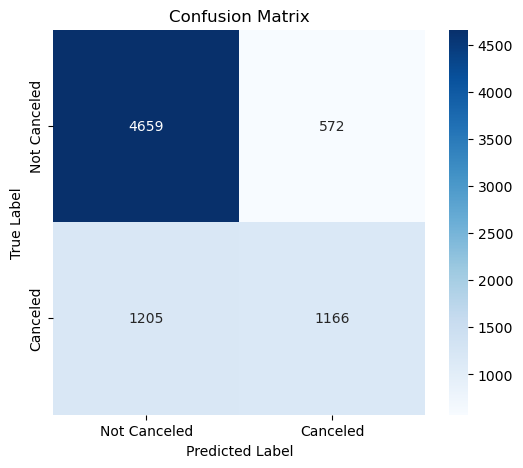

{'Accuracy': 0.7662457248092607, 'Precision': 0.6708860759493671, 'Recall': 0.49177562210037956, 'F1 Score': 0.5675346799707958}


In [12]:
def evaluate_deployed_classifier(predictor, x_eval, y_eval):
    predictor.serializer = CSVSerializer()  # Ensure the predictor uses the correct serialization

    # Copy test features and labels
    x_test = x_eval.copy()
    y_test = y_eval.copy()

    predictions = predictor.predict(x_test.values)  # Get predictions from the deployed endpoint

    # Ensure correct extraction of predicted labels
    try:
        predicted_labels = [int(result["predicted_label"]) for result in predictions["predictions"]]
    except (KeyError, TypeError) as e:
        print(f"Error extracting predictions: {e}")
        return None  # Stop execution if predictions are not correctly formatted

    # Compute evaluation metrics
    acc = accuracy_score(y_test, predicted_labels)
    prec = precision_score(y_test, predicted_labels, zero_division=0)
    rec = recall_score(y_test, predicted_labels, zero_division=0)
    f1 = f1_score(y_test, predicted_labels, zero_division=0)

    # Print evaluation metrics
    print("\n **Evaluation Metrics:**")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}\n")

    # Print detailed classification report
    print("**Classification Report:**")
    print(classification_report(y_test, predicted_labels, target_names=["Not Canceled", "Canceled"]))

    # Compute and visualize the confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    print("\n**Confusion Matrix (Raw Values):**")
    print(cm)

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Not Canceled", "Canceled"],
                yticklabels=["Not Canceled", "Canceled"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Return computed evaluation metrics
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

print(evaluate_deployed_classifier(predictor, x_eval, y_eval))


<b><h4>13: Query With Test Data</h4></b>
<h5>Illustrate how business can query model to predict cancellations.</h5>

In [13]:
sample_data = x_eval.head(5)

# Convert the selected data to a NumPy array.
# This format is required by the predictor's CSVSerializer.
input_data = sample_data.values

# Request predictions from the deployed endpoint using the sample data.
predictions = predictor.predict(input_data)

# Process the response if it contains the 'predictions' key.
if "predictions" in predictions:
    # Extract the predicted probabilities from each result.
    y_pred_test_probs = [float(result["score"]) for result in predictions["predictions"]]
    
    # Define a threshold to convert probabilities into binary class labels.
    threshold = 0.5
    # Convert probabilities to binary labels: 1 if above the threshold, else 0.
    y_pred_test_classes = [1 if prob > threshold else 0 for prob in y_pred_test_probs]
    
    print("\nTest Probabilities on 5 samples:", y_pred_test_probs)
    print("Test Predicted Classes on 5 samples:", y_pred_test_classes)
else:
    print("No 'predictions' key found in the response:", predictions)

# Retrieve the actual target values for the selected sample data.
sample_targets = y_eval.loc[sample_data.index]
print("Actual:", sample_targets.tolist())


Test Probabilities on 5 samples: [0.0006535485736094415, 0.37561753392219543, 0.20503410696983337, 0.3035081624984741, 0.19358386099338531]
Test Predicted Classes on 5 samples: [0, 0, 0, 0, 0]
Actual: [0.0, 0.0, 0.0, 0.0, 0.0]



### 14: Delete Sagemaker Endpoint
**Business Objective:** Save money after training  

In [14]:
def delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_config_name):
    try:
        sm_client.describe_endpoint(EndpointName=endpoint_name)
        sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Deleted endpoint: {endpoint_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint '{endpoint_name}' does not exist.")
        else:
            raise e
    try:
        sm_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Deleted endpoint config: {endpoint_config_name}")
    except sm_client.exceptions.ClientError as e:
        if "Could not find endpoint configuration" in str(e) or "ResourceNotFound" in str(e):
            print(f"Endpoint config '{endpoint_config_name}' does not exist.")
        else:
            raise e

# Automatically delete the endpoint and its configuration.
delete_model("binary-learner-endpoint")
delete_sagemaker_endpoint_and_config(sm_client, endpoint_name, endpoint_name)

[02/09/25 04:24:41] INFO     Model 'binary-learner-endpoint' does not exist or is already deleted.   ]8;id=7735;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=922745;file:///tmp/ipykernel_18089/30082138.py#71\71]8;;\

[02/09/25 04:24:42] INFO     Model fully deleted.                                                    ]8;id=675999;file:///tmp/ipykernel_18089/30082138.py\30082138.py]8;;\:]8;id=921359;file:///tmp/ipykernel_18089/30082138.py#83\83]8;;\

Deleted endpoint: binary-learner-endpoint
Deleted endpoint config: binary-learner-endpoint
